In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor


# Data import and selection

In [16]:
data_import = pd.read_csv('../Data/SQLout_employees.csv')
data2018ft = data_import.query('arrangement == "FT" & year==2018', inplace=False)[
     ['nace', 'esize_class', 'gender', 'age_class', 'lpk','education', 'experience', 'hourly_rate']
]

data2018ft['lpk'] ='p'+ data2018ft['lpk'].astype(str)
data2018ft = data2018ft.rename(columns={'hourly_rate': 'target'})
print('Length of dataset: ', len(data2018ft))
data2018ft.head()

Length of dataset:  36785


,nace,esize_class,gender,age_class,lpk,education,experience,target
44952,C,1_49,M,50-59,p722,G2,13,8.13
44953,C,1_49,M,40-49,p721,G2,13,8.20
44954,C,1_49,M,50-59,p722,G2,13,8.20
44955,C,1_49,F,40-49,p334,G2,0,2.51
44956,M,50_249,F,40-49,p522,G2,18,2.19


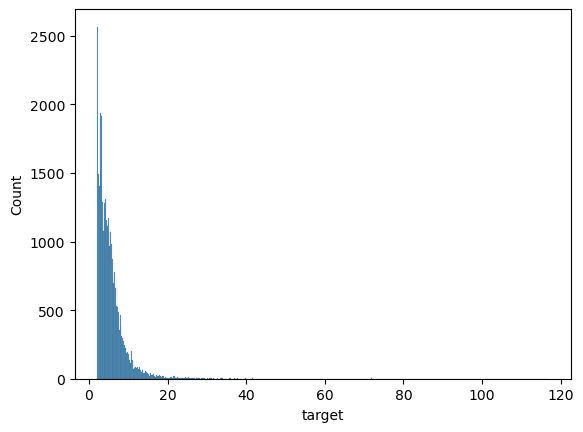

In [17]:
sns.histplot(data2018ft['target']);

# Effect of outlier boundaries on model accuracy

## Test with XGBoost pipline (not optimized)

In [18]:
def observations_between_thresholds(df, lower_threshold=0.05, upper_threshold=0.95):
    """Select observations, with hourly rate between
     thresholds for lpk groups. Thresholds are defined by quantile"""
    df['rank'] = df.groupby('lpk')['target'].rank(pct=True).copy()
    df = df.query('rank < @upper_threshold & rank > @lower_threshold')
    df = df.drop(columns='rank')     
    return df

In [19]:
upper_threshold = 0.80
lower_threshold = 0.20

In [20]:
data = data2018ft.copy()

data = observations_between_thresholds(data, lower_threshold=lower_threshold, upper_threshold=upper_threshold)
data = data.groupby('lpk').filter(lambda x: len(x) > 50)

y = data['target']
X = data.drop(columns='target')

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)

print('Dataset lengths:',
    'train', len(y_train), ', test', len(y_test))


Dataset lengths: train 16924 , test 4232


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_preprocessor = Pipeline(steps=[("scaler", StandardScaler())])

categorical_preprocessor = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, ['nace', 'esize_class', 'gender', 'age_class', 'lpk', 'education']),
        ("numerical", numeric_preprocessor, ['experience'])
    ]
)

model = Pipeline([('prep', preprocessor), ('regr', XGBRegressor())])
model.fit(X=X_train, y=y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['nace', 'esize_class',
                                                   'gender', 'age_class', 'lpk',
                                                   'education']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['experience'])])),
                ('regr',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              co...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=0, ...))])

In [22]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
residuals_test=y_test_pred-y_test
r_residuals_test=(y_test_pred-y_test)/y_test*100

print('Train: RMSE=', np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3),
    ' R2=', r2_score(y_train, y_train_pred).round(3))

print('Test: RMSE=', np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3),
    ' R2=', r2_score(y_test, y_test_pred).round(3))

y_train_mean = np.mean(y_train)


Train: RMSE= 0.908  R2= 0.826
Test: RMSE= 1.096  R2= 0.732


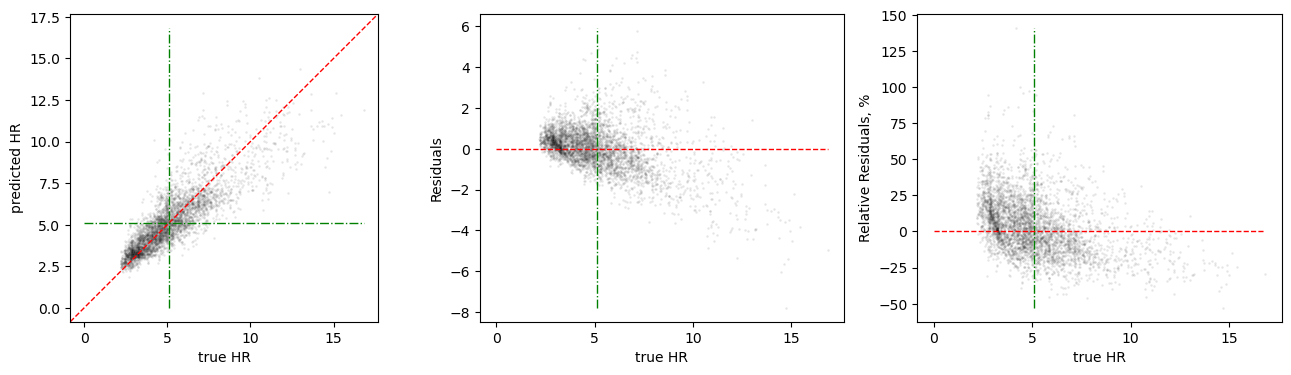

In [23]:

fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharex=True)
sns.scatterplot(ax=ax[0], x=y_test, y=y_test_pred,  s=3, color='black', alpha=0.1)
#sns.kdeplot(ax=ax[0],  x=y_test, y=y_test_pred, alpha=0.5 )
ax[0].set_xlabel('true HR')
ax[0].set_ylabel('predicted HR')
ax[0].set_aspect(aspect=1, adjustable=None, anchor=None, share=False)
ax[0].plot((0,1), (0, 1), transform=ax[0].transAxes, linestyle='--', color='r', lw=1)
ax[0].vlines(ymin=0, ymax=max(y_test) , x=y_train_mean, linestyle='-.', color='g', lw=1)
ax[0].hlines(xmin=0, xmax=max(y_test) , y=y_train_mean, linestyle='-.', color='g', lw=1)

sns.scatterplot(ax=ax[1],  x=y_test, y=residuals_test,  s=3, color='black', alpha=0.1)
#sns.kdeplot(ax=ax[1], x=y_test, y=residuals_test, alpha=0.5 )
ax[1].set_xlabel('true HR')
ax[1].set_ylabel('Residuals')
ax[1].vlines(ymin=min(residuals_test), ymax=max(residuals_test) , x=y_train_mean, linestyle='-.', color='g', lw=1)
ax[1].hlines(xmin=0, xmax=max(y_test) , y=0, linestyle='--', color='r', lw=1)

sns.scatterplot(ax=ax[2],  x=y_test, y=r_residuals_test,  s=3, color='black', alpha=0.1)
#sns.kdeplot(ax=ax[2],  x=y_test, y=r_residuals_test, alpha=0.5 )
ax[2].set_xlabel('true HR')
ax[2].set_ylabel('Relative Residuals, %')
ax[2].vlines(ymin=min(r_residuals_test), ymax=max(r_residuals_test) , x=y_train_mean, linestyle='-.', color='g', lw=1)
ax[2].hlines(xmin=0, xmax=max(y_test) , y=0, linestyle='--', color='r', lw=1);

## Effect of combined upper and lower outlier threshold

In [24]:
upper_threshold_list = []
lower_threshold_list = []
min_value_list = []
max_value_list = []
train_size = []
test_size = []
rmse_train_list = []
rmse_test_list = []
r2_train_list = []
r2_test_list = []

for upper_threshold in np.linspace(0.6, 1.0, 9).round(2):
    for lower_threshold in np.linspace(0.0, 0.3, 7).round(2):
        
        upper_threshold_list.append(upper_threshold)
        lower_threshold_list.append(lower_threshold)

        data = data2018ft.copy()
        df = observations_between_thresholds(data, lower_threshold=lower_threshold, upper_threshold=upper_threshold)
        
        y = df['target']
        X = df.drop(columns='target')
        
        min_value_list.append(min(y))
        max_value_list.append(max(y))

        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
        
        train_size.append(len(y_train))
        test_size.append(len(y_test))
        

        model.fit(X=X_train, y=y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        r2_train = r2_score(y_train, y_train_pred)


        rmse_test = np.sqrt(mean_squared_error(y_train, y_train_pred))
        r2_test = r2_score(y_train, y_train_pred)

        rmse_train_list.append(rmse_train)
        rmse_test_list.append(rmse_test)
        r2_train_list.append(r2_train)
        r2_test_list.append(r2_test)

size_effect = pd.DataFrame({'upper': upper_threshold_list,
                            'lower': lower_threshold_list,
                            'min':min_value_list,
                            'max':max_value_list,
                            'train_size': train_size,
                            'test_size': test_size,
                            'rmse_train': rmse_train_list,
                            'rmse_test': rmse_test_list,
                            'r2_train': r2_train_list,
                            'r2_test': r2_test_list
                            } )
   
size_effect.head()


,upper,lower,min,max,train_size,test_size,rmse_train,rmse_test,r2_train,r2_test
0,0.6,0.00,2.13,12.95,17603,4401,0.829786,0.829786,0.750446,0.750446
1,0.6,0.05,2.17,12.95,16144,4036,0.761133,0.761133,0.785551,0.785551
2,0.6,0.10,2.19,12.95,14740,3685,0.696446,0.696446,0.826588,0.826588
3,0.6,0.15,2.19,12.95,13273,3319,0.637287,0.637287,0.854162,0.854162
4,0.6,0.20,2.19,12.95,11700,2926,0.563631,0.563631,0.890000,0.890000


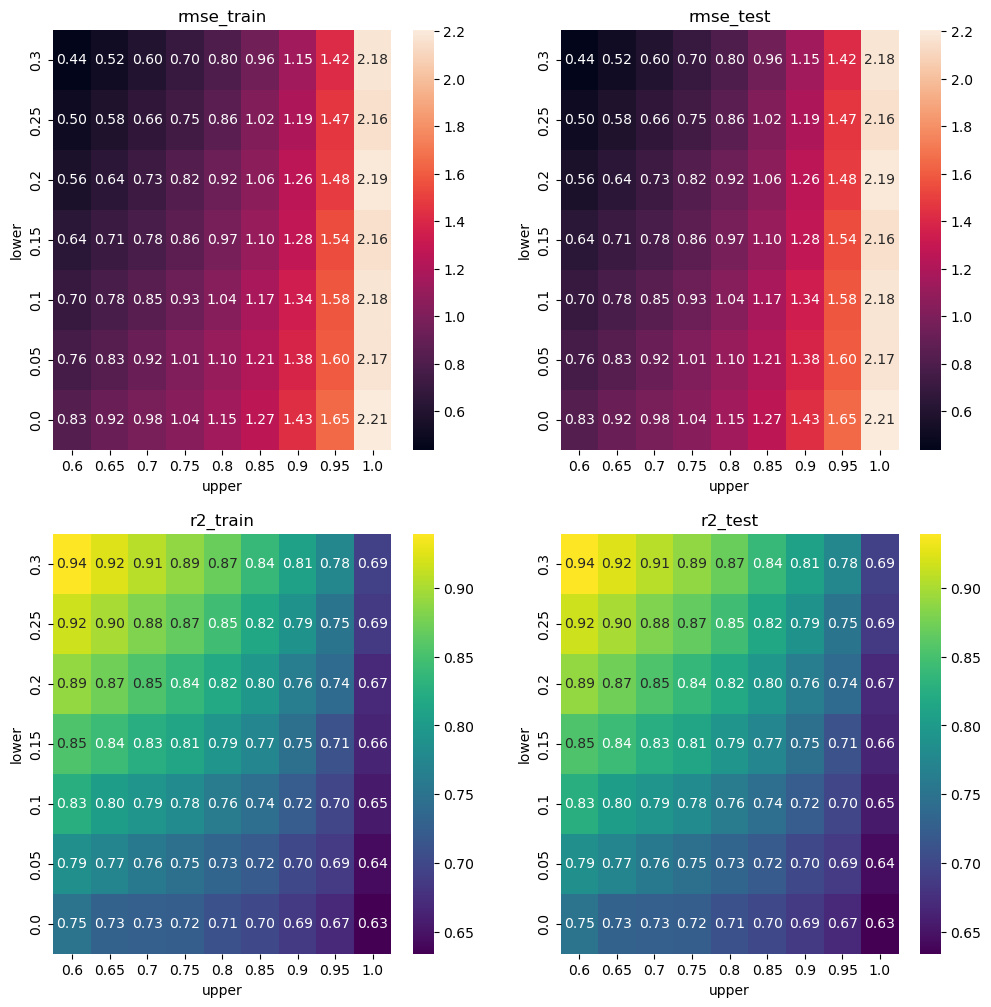

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
sns.heatmap(ax=ax[0, 0], data = size_effect[['lower', 'upper', 'rmse_train']].pivot(
    index='lower', columns='upper', values='rmse_train'), annot=True, fmt=".2f"
)
ax[0, 0].set_title('rmse_train')
ax[0, 0].invert_yaxis()
sns.heatmap(ax=ax[0, 1], data = size_effect[['lower', 'upper', 'rmse_test']].pivot(
    index='lower', columns='upper', values='rmse_test'), annot=True, fmt=".2f"
)
ax[0, 1].set_title('rmse_test')
ax[0, 1].invert_yaxis()
sns.heatmap(ax=ax[1, 0], data = size_effect[['lower', 'upper', 'r2_train']].pivot(
    index='lower', columns='upper', values='r2_train'), cmap="viridis", annot=True, fmt=".2f"
)
ax[1, 0].set_title('r2_train')
ax[1, 0].invert_yaxis()
sns.heatmap(ax=ax[1, 1], data = size_effect[['lower', 'upper', 'r2_test']].pivot(
    index='lower', columns='upper', values='r2_test'), cmap="viridis", annot=True, fmt=".2f"
)
ax[1, 1].set_title('r2_test')
ax[1, 1].invert_yaxis();


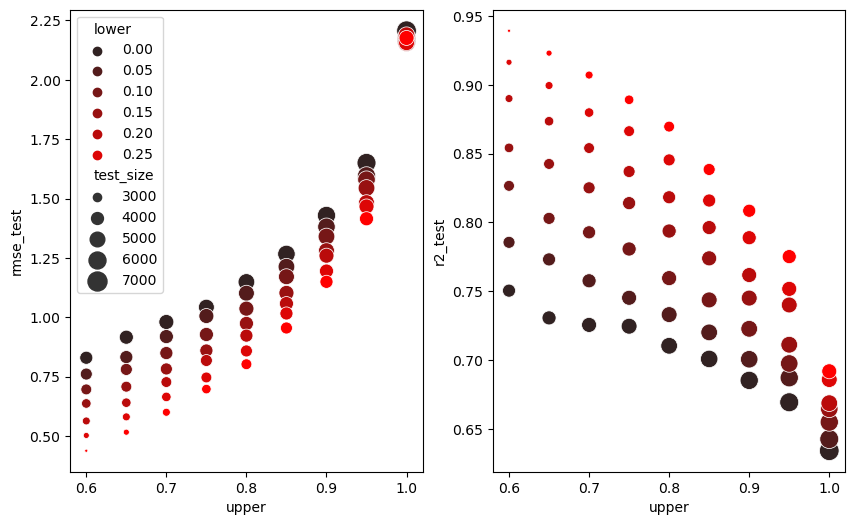

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.scatterplot(ax=ax[0], data=size_effect, x='upper', y='rmse_test', size='test_size', sizes=(5, 200), hue='lower', palette='dark:red')
sns.scatterplot(ax=ax[1], data=size_effect, x='upper', y='r2_test', size='test_size', sizes=(5, 200), hue='lower', palette='dark:red',
                 legend = False);


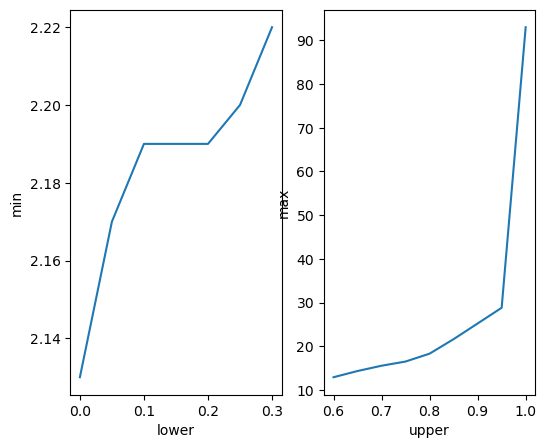

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(6, 5))
sns.lineplot(ax=ax[0], data=size_effect[['lower', 'min']].drop_duplicates(), x='lower', y='min')
sns.lineplot(ax=ax[1], data=size_effect[['upper', 'max']].drop_duplicates(), x='upper', y='max');

# Save data without outliers for all ML models

In [28]:
upper_threshold = 0.90
lower_threshold = 0.0
data = data2018ft.copy()

data = observations_between_thresholds(data, lower_threshold=lower_threshold, upper_threshold=upper_threshold)
data = data.groupby('lpk').filter(lambda x: len(x) > 50)
data.to_csv('../Data/LT_DU_data_for_ML.csv', index=False)
